In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import matplotlib
import sys
import colorcet as cc
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

import celeri

In [3]:
def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, fraction=0.046, pad=0.04)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)
    plt.gca().set_aspect("equal")


def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values


def get_coupling(
    x1,
    x2,
    estimated_slip,
    kinematic_slip,
    smoothing_length_scale,
    kinematic_slip_regularization_scale,
):
    """
    Calculate coupling with optional smoothing and regularization
    """

    # Smooth kinematic rates
    if smoothing_length_scale > 0.0:
        kinematic_slip = smooth_irregular_data(
            x1,
            x2,
            kinematic_slip,
            length_scale=smoothing_length_scale,
        )

    # Set the minimum value of the kinematic rates
    # The purpose of this is to prevent coupling blow up as the kinematic
    # rates approach zero
    if kinematic_slip_regularization_scale > 0:
        kinematic_slip[np.abs(kinematic_slip) < kinematic_slip_regularization_scale] = (
            kinematic_slip_regularization_scale
            * np.sign(
                kinematic_slip[
                    np.abs(kinematic_slip) < kinematic_slip_regularization_scale
                ]
            )
        )

    # Calculate coupling
    coupling = estimated_slip / kinematic_slip
    return coupling, kinematic_slip


def update_slip_rate_bounds(
    meshes,
    mesh_idx,
    tde_coupling_ss,
    tde_coupling_ds,
    kinematic_tde_rates_ss,
    kinematic_tde_rates_ds,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]

    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]

    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ds > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    # Find indices of mesh elements with negative kinematic rate
    neg_kinematic_ss_idx = np.where(kinematic_tde_rates_ss < 0)[0]
    neg_kinematic_ds_idx = np.where(kinematic_tde_rates_ds < 0)[0]
    pos_kinematic_ss_idx = np.where(kinematic_tde_rates_ss >= 0)[0]
    pos_kinematic_ds_idx = np.where(kinematic_tde_rates_ds >= 0)[0]

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_neg_kinematic_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, neg_kinematic_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_neg_kinematic_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, neg_kinematic_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_neg_kinematic_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, neg_kinematic_ds_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_neg_kinematic_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, neg_kinematic_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_pos_kinematic_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, pos_kinematic_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_pos_kinematic_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, pos_kinematic_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_pos_kinematic_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, pos_kinematic_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_pos_kinematic_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, pos_kinematic_ds_idx
    )

    # Calculate total number of OOB coupling constraints
    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )

    # Make vectors for update slip rates (not neccesary but useful for debugging)
    updated_ss_bounds_lower = np.copy(current_ss_bounds_lower)
    updated_ss_bounds_upper = np.copy(current_ss_bounds_upper)
    updated_ds_bounds_lower = np.copy(current_ds_bounds_lower)
    updated_ds_bounds_upper = np.copy(current_ds_bounds_upper)

    # Calculate midpoint slip rate assciated with midpoint coupling
    mid_point_ss_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )
    mid_point_ds_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )

    mid_point_ss_rate = mid_point_ss_coupling * kinematic_tde_rates_ss
    mid_point_ds_rate = mid_point_ds_coupling * kinematic_tde_rates_ds

    # Update bounds with a linear approach towards midpoint
    new_ss_bounds_lower = current_ss_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_lower
    )

    new_ss_bounds_upper = current_ss_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_upper
    )

    new_ds_bounds_lower = current_ds_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_lower
    )

    new_ds_bounds_upper = current_ds_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_upper
    )

    # Update slip rate bounds
    # NOTE: Note upper and lower swap here for negative kinmatic cases (2nd and 3rd quadrants)
    # Negative kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_kinematic_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_kinematic_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_kinematic_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_kinematic_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_kinematic_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_kinematic_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_kinematic_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_kinematic_ds]
    )

    # Positive kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_kinematic_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_kinematic_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_kinematic_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_kinematic_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_kinematic_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_kinematic_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_kinematic_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_kinematic_ds]
    )

    return (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    )


def check_coupling_bounds_single_mesh(
    operators,
    index,
    meshes,
    mesh_idx,
    estimation_qp,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    # Get kinematic rates on mesh elements
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Get estimated elastic rates on mesh elements
    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
        ]
    )

    # Calculate strike-slip and dip-slip coupling
    tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[0::2],
        kinematic_tde_rates[0::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[1::2],
        kinematic_tde_rates[1::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    # Update slip rate bounds
    (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    ) = update_slip_rate_bounds(
        meshes,
        mesh_idx,
        tde_coupling_ss,
        tde_coupling_ds,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        current_ss_bounds_lower,
        current_ss_bounds_upper,
        current_ds_bounds_lower,
        current_ds_bounds_upper,
    )

    return (
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        estimated_tde_rates[0::2],
        estimated_tde_rates[1::2],
        n_oob,
    )

# Read data and pre-process

In [ ]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi_coupling.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

# Generate all operators, weighting, and data vector for KL+QP problem

In [ ]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

# Get rotation to TDE kinematic slip rate operator for all meshes tied to segments
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

# Solve bounded KL+QP problem

In [ ]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

# Plot KL+QP estimation

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Iterative coupling: iteration loop

In [ ]:
# Get total number of segment meshes
n_segment_meshes = np.max(segment.patch_file_name).astype(int) + 1

# Count total number of triangles in segment meshes
n_segment_meshes_tri = 0
for i in range(n_segment_meshes):
    n_segment_meshes_tri += meshes[i].n_tde

# Create initial mesh slip rate bound arrays
current_ss_bounds_lower = [None] * n_segment_meshes
current_ss_bounds_upper = [None] * n_segment_meshes
current_ds_bounds_lower = [None] * n_segment_meshes
current_ds_bounds_upper = [None] * n_segment_meshes
for i in range(n_segment_meshes):
    current_ss_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(meshes[i].n_tde)
    current_ss_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(meshes[i].n_tde)
    current_ds_bounds_lower[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(meshes[i].n_tde)
    current_ds_bounds_upper[i] = meshes[
        i
    ].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(meshes[i].n_tde)

# Storage for number of OOB coupling values per mesh
n_oob_vec = np.zeros((n_segment_meshes, 1))

# Initialize lists and arrays for storing various slip rates
store_ss_lower = [None] * n_segment_meshes
store_ss_upper = [None] * n_segment_meshes
store_ds_lower = [None] * n_segment_meshes
store_ds_upper = [None] * n_segment_meshes
store_ss_kinematic = [None] * n_segment_meshes
store_ss_elcon = [None] * n_segment_meshes
store_ds_kinematic = [None] * n_segment_meshes
store_ds_elcon = [None] * n_segment_meshes
for i in range(n_segment_meshes):
    store_ss_lower[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))
    store_ss_upper[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))
    store_ds_lower[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))
    store_ds_upper[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))
    store_ss_kinematic[i] = np.zeros(
        (meshes[i].n_tde, command.coupling_bounds_max_iter)
    )
    store_ss_elcon[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))
    store_ds_kinematic[i] = np.zeros(
        (meshes[i].n_tde, command.coupling_bounds_max_iter)
    )
    store_ds_elcon[i] = np.zeros((meshes[i].n_tde, command.coupling_bounds_max_iter))

# Variables for tracking overall convergence
tde_total = 0
for i in range(3):
    tde_total += meshes[i].n_tde
total_percentages = list()

# Coupling bound iteration
continue_iterating = True
i = 0
while continue_iterating:
    # Create storage for updates slip rate constraints
    updated_qp_inequality_constraints_data_vector = np.copy(
        qp_inequality_constraints_data_vector
    )

    # Create storage for n OOB
    current_noob = np.zeros((n_segment_meshes, 1))

    # Loop over meshes
    for j in range(n_segment_meshes):
        (
            updated_ss_bounds_lower,
            updated_ss_bounds_upper,
            updated_ds_bounds_lower,
            updated_ds_bounds_upper,
            kinematic_tde_rates_ss,
            kinematic_tde_rates_ds,
            estimated_tde_rates_ss,
            estimated_tde_rates_ds,
            n_oob,
        ) = check_coupling_bounds_single_mesh(
            operators,
            index,
            meshes,
            j,  # This is the mesh index
            estimation_qp,
            current_ss_bounds_lower[j],
            current_ss_bounds_upper[j],
            current_ds_bounds_lower[j],
            current_ds_bounds_upper[j],
        )
        logger.info(f"Iteration: {i}, Mesh: {j}, NOOB: {n_oob}")

        # Store total number of OOB elements at this iteration step
        n_oob_vec[j, i] = n_oob

        # Build and insert update slip rate bounds into QP inequality vector
        updated_lower_bounds = -1.0 * celeri.interleave2(
            updated_ss_bounds_lower, updated_ds_bounds_lower
        )
        updated_upper_bounds = celeri.interleave2(
            updated_ss_bounds_upper, updated_ds_bounds_upper
        )
        updated_bounds = np.hstack((updated_lower_bounds, updated_upper_bounds))

        # Insert TDE lower bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                j
            ] : index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j]
        ] = updated_lower_bounds

        # Insert TDE upper bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j] : index.qp_constraint_tde_rate_end_row_eigen[j]
        ] = updated_upper_bounds

        # Set *updated* to *current* for next iteration
        current_ss_bounds_lower[j] = np.copy(updated_ss_bounds_lower)
        current_ss_bounds_upper[j] = np.copy(updated_ss_bounds_upper)
        current_ds_bounds_lower[j] = np.copy(updated_ds_bounds_lower)
        current_ds_bounds_upper[j] = np.copy(updated_ds_bounds_upper)

        # Store values for visualization and debugging
        store_ss_lower[j][:, i] = current_ss_bounds_lower[j]
        store_ss_upper[j][:, i] = current_ss_bounds_upper[j]
        store_ds_lower[j][:, i] = current_ds_bounds_lower[j]
        store_ds_upper[j][:, i] = current_ds_bounds_upper[j]
        store_ss_elcon[j][:, i] = estimated_tde_rates_ss
        store_ds_elcon[j][:, i] = estimated_tde_rates_ds
        store_ss_kinematic[j][:, i] = kinematic_tde_rates_ss
        store_ds_kinematic[j][:, i] = kinematic_tde_rates_ds

    # Store new number of OOB elements permesh
    n_oob_vec = np.hstack((n_oob_vec, current_noob))

    # QP solve with updated TDE slip rate constraints
    solution_qp = celeri.lsqlin_qp(
        operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
        data_vector_eigen * np.sqrt(weighting_vector_eigen),
        0,
        qp_inequality_constraints_matrix,  # Inequality matrix
        updated_qp_inequality_constraints_data_vector,  # Inequality data vector
        None,
        None,
        None,
        None,
        None,
        {"show_progress": False},
    )

    if solution_qp["status"] != "optimal":
        logger.error(f" ")
        logger.error(f"NON OPTIMAL SOLUTION AT: {i=}")
        logger.error(f" ")
        sys.exit()

    # Create estimation data structure and calculate derived quantities
    estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
    estimation_qp.operator = operators.eigen
    celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)

    # Calculate total percentage of OOB elements to determine if we iterate again
    total_oob = np.sum(n_oob_vec[:, i], axis=0)
    total_percentages.append(total_oob / (2 * tde_total) * 100)
    total_percentage_satisfied = 100 - total_percentages[-1]
    logger.info(
        f"Iteration: {i}, Total %TDE inside coupling bounds: {100-total_percentages[-1]:0.3f}"
    )
    print(" ")

    # Decide if iteration should continue
    if i <= command.coupling_bounds_max_iter:
        if (
            total_percentage_satisfied
            <= command.coupling_bounds_total_percentage_satisfied_target
        ):
            continue_iterating = True
            i += 1
        else:
            continue_iterating = False
    else:
        continue_iterating = False
    n_iter = np.copy(i)

# Write output
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

# Delete columns less that n_iter
for j in range(n_segment_meshes):
    store_ss_lower[j] = store_ss_lower[j][:, 0:n_iter]
    store_ss_upper[j] = store_ss_upper[j][:, 0:n_iter]
    store_ds_lower[j] = store_ds_lower[j][:, 0:n_iter]
    store_ds_upper[j] = store_ds_upper[j][:, 0:n_iter]
    store_ss_elcon[j] = store_ss_elcon[j][:, 0:n_iter]
    store_ds_elcon[j] = store_ds_elcon[j][:, 0:n_iter]
    store_ss_kinematic[j] = store_ss_kinematic[j][:, 0:n_iter]
    store_ds_kinematic[j] = store_ds_kinematic[j][:, 0:n_iter]

# Plot convergence with iterations

In [ ]:
def plot_iterative_convergence(mesh_names, meshes, n_oob_vec, n_iter):
    # Calculate total mesh elements
    tde_total = 0
    for i in range(3):
        tde_total += meshes[i].n_tde

    total_oob = np.sum(n_oob_vec, axis=0)
    total_percentages = total_oob / (2 * tde_total) * 100
    idx = np.arange(len(total_percentages))

    # Plot convergence
    plt.figure(figsize=(4, 3))
    label_string = f"total ({total_percentages[n_iter]:0.2f}%)"
    plt.fill_between(idx, total_percentages, color="lightgray", label=label_string)
    for i in range(len(mesh_names)):
        percentages = n_oob_vec[i, :] / (2 * meshes[i].n_tde) * 100
        label_string = f"{mesh_names[i]} ({percentages[n_iter]:0.2f}%)"
        plt.plot(idx, percentages, linewidth=1.0, label=label_string)

    plt.xlabel("iteration")
    plt.ylabel("% OOB")
    plt.xlim([0, n_iter - 1])
    plt.ylim([0, 100])
    plt.xticks([0, n_iter - 1])
    plt.yticks([0, 100])
    legend_handle = plt.legend(
        fancybox=False, framealpha=1, facecolor="white", edgecolor="black"
    )
    legend_handle.get_frame().set_linewidth(0.5)
    plt.show()

    # Plot convergence
    plt.figure(figsize=(4, 3))
    label_string = f"total ({100 - total_percentages[n_iter]:0.2f}%)"
    plt.fill_between(
        idx, 100 - total_percentages, color="lightgray", label=label_string
    )
    for i in range(len(mesh_names)):
        percentages = 100 - n_oob_vec[i, :] / (2 * meshes[i].n_tde) * 100
        label_string = f"{mesh_names[i]} ({percentages[n_iter]:0.2f}%)"
        plt.plot(idx, percentages, linewidth=1.0, label=label_string)

    plt.xlabel("iteration")
    plt.ylabel("% IB")
    plt.xlim([0, n_iter - 1])
    plt.ylim([0, 100])
    plt.xticks([0, n_iter - 1])
    plt.yticks([0, 100])
    legend_handle = plt.legend(
        fancybox=False, framealpha=1, facecolor="white", edgecolor="black"
    )
    legend_handle.get_frame().set_linewidth(0.5)
    plt.show()


plot_iterative_convergence(
    ["Nankai", "Japan", "Sagami"], meshes, n_oob_vec, n_iter=n_iter
)

# Plot complete model result after coupling iterations

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [ ]:
def plot_common_elements():
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.xticks([-90, 0, 90])
    plt.yticks([-90, 0, 90])
    plt.gca().set_aspect("equal")


def plot_evolution(field1, field2, mesh_idx):
    LINE_COLOR = "lightgray"
    for i in range(meshes[mesh_idx].n_tde):
        plt.plot(
            field1[i, :],
            field2[i, :],
            "-",
            linewidth=0.1,
            color=LINE_COLOR,
            zorder=1,
        )
    plt.plot(field1[:, -1], field2[:, -1], ".k", markersize=0.5)


def plot_coupling_evolution(mesh_idx):
    def plot_background():
        REGULARIZATION_RATE = 1.0
        levels = 101
        j_cutoff = 50.0
        j = np.linspace(-100, 100, 1000)
        b = np.linspace(-100, 100, 1000)
        j_grid, b_grid = np.meshgrid(j, b)
        j_grid_orig = np.copy(j_grid)
        b_grid_orig = np.copy(b_grid)
        coupling, _ = get_coupling(
            0,
            0,
            b_grid.flatten(),
            j_grid.flatten(),
            smoothing_length_scale=0.0,
            kinematic_slip_regularization_scale=REGULARIZATION_RATE,
        )
        coupling_grid = np.reshape(coupling, (1000, 1000))
        coupling_grid[coupling_grid > 1.0] = np.nan
        coupling_grid[coupling_grid < 0.0] = np.nan

        # Create half colormap
        # Retrieve a colorcet colormap
        # full_cmap = cc.cm["coolwarm_r"]  # Replace with your desired colormap
        # full_cmap = cc.cm["CET_D8_r"]  # Replace with your desired colormap
        # full_cmap = cc.cm["cwr_r"]  # Replace with your desired colormap
        full_cmap = cc.cm["bmy_r"]  # Replace with your desired colormap

        # Extract half of the colormap
        n_colors = full_cmap.N  # Total number of colors in the colormap
        half_cmap = LinearSegmentedColormap.from_list(
            "half_cmap", full_cmap(np.linspace(0, 0.5, n_colors // 2))
        )
        # cmap = half_cmap.reversed()
        cmap = half_cmap

        ch = plt.contourf(
            j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels
        )
        return ch

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    ch = plot_background()
    plot_evolution(store_ss_kinematic[mesh_idx], store_ss_elcon[mesh_idx], mesh_idx)
    plot_common_elements()
    plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
    plt.ylabel("$v$ strike-slip elastic (mm/yr)")
    cax = inset_axes(
        plt.gca(),
        width="20%",
        height="30%",
        loc="upper right",
        bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
        bbox_transform=plt.gca().transAxes,
        borderpad=0,
    )
    cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

    plt.subplot(2, 2, 2)
    ch = plot_background()
    plot_evolution(store_ss_kinematic[mesh_idx], store_ss_lower[mesh_idx], mesh_idx)
    plot_evolution(store_ss_kinematic[mesh_idx], store_ss_upper[mesh_idx], mesh_idx)
    plot_common_elements()
    plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
    plt.ylabel("$v$ strike-slip bounds (mm/yr)")
    cax = inset_axes(
        plt.gca(),
        width="20%",
        height="30%",
        loc="upper right",
        bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
        bbox_transform=plt.gca().transAxes,
        borderpad=0,
    )
    cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

    plt.subplot(2, 2, 3)
    ch = plot_background()
    plot_evolution(store_ds_kinematic[mesh_idx], store_ds_elcon[mesh_idx], mesh_idx)
    plot_common_elements()
    plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
    plt.ylabel("$v$ dip-slip elastic (mm/yr)")
    cax = inset_axes(
        plt.gca(),
        width="20%",
        height="30%",
        loc="upper right",
        bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
        bbox_transform=plt.gca().transAxes,
        borderpad=0,
    )
    cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

    plt.subplot(2, 2, 4)
    ch = plot_background()
    plot_evolution(store_ds_kinematic[mesh_idx], store_ds_lower[mesh_idx], mesh_idx)
    plot_evolution(store_ds_kinematic[mesh_idx], store_ds_upper[mesh_idx], mesh_idx)
    plot_common_elements()
    plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
    plt.ylabel("$v$ dip-slip bounds (mm/yr)")
    cax = inset_axes(
        plt.gca(),
        width="20%",
        height="30%",
        loc="upper right",
        bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
        bbox_transform=plt.gca().transAxes,
        borderpad=0,
    )
    cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")
    plt.suptitle(f"{meshes[mesh_idx].file_name}")
    plt.show()


for i in range(n_segment_meshes):
    plot_coupling_evolution(i)

# Plot final slip rates and coupling distributions

In [ ]:
def quick_plot_coupling(mesh_idx, operators, estimation_qp):
    # Multiply rotation vector components by TDE slip rate partials
    kinematic = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    elastic = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
        ]
    )

    # Calculate final coupling and smoothed kinematic
    tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        elastic[0::2],
        kinematic[0::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        elastic[1::2],
        kinematic[1::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    # Strike-slip
    plt.figure(figsize=(15, 2))
    plt.subplot(1, 4, 1)
    plot_mesh(meshes[mesh_idx], kinematic[0::2], plt.gca())
    plt.title("ss kinematic")

    plt.subplot(1, 4, 2)
    plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ss_smooth, plt.gca())
    plt.title("ss kinematic (smooth)")

    plt.subplot(1, 4, 3)
    plot_mesh(meshes[mesh_idx], elastic[0::2], plt.gca())
    plt.title("ss elastic")

    plt.subplot(1, 4, 4)
    plot_mesh(meshes[mesh_idx], tde_coupling_ss, plt.gca())
    plt.title("ss coupling")

    # Dip-slip
    plt.figure(figsize=(15, 2))
    plt.subplot(1, 4, 1)
    plot_mesh(meshes[mesh_idx], kinematic[1::2], plt.gca())
    plt.title("ds kinematic")

    plt.subplot(1, 4, 2)
    plot_mesh(meshes[mesh_idx], kinematic_tde_rates_ds_smooth, plt.gca())
    plt.title("ds kinematic (smooth)")

    plt.subplot(1, 4, 3)
    plot_mesh(meshes[mesh_idx], elastic[1::2], plt.gca())
    plt.title("ds elastic")

    plt.subplot(1, 4, 4)
    plot_mesh(meshes[mesh_idx], tde_coupling_ds, plt.gca())
    plt.title("ds coupling")

    plt.show()


for i in range(n_segment_meshes):
    quick_plot_coupling(i, operators, estimation_qp)

# Fancy visualization.  Hacky but customizable.

In [ ]:
import matplotlib
import warnings
from scipy.interpolate import RBFInterpolator
from matplotlib import path
import scipy.io as sio
import pandas as pd

MAX_VEL = 60

n_grid_x = 500
n_grid_y = 500


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate():
    # Observation coordinates and data
    # x_vec = np.linspace(231, 239, n_grid_x)
    # y_vec = np.linspace(38, 52, n_grid_y)
    x_vec = np.linspace(130, 140, n_grid_x)
    y_vec = np.linspace(30, 37, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid


def common_plot_elements(segment, lon_range, lat_range):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
    plt.plot(
        WORLD_BOUNDARIES["lon"],
        WORLD_BOUNDARIES["lat"],
        color="gray",
        linewidth=0.25,
    )
    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.xticks([lon_range[0], lon_range[1]])
    plt.yticks([lat_range[0], lat_range[1]])
    plt.gca().set_aspect("equal", adjustable="box")


lon_range = [130, 139]
lat_range = [30, 37]
quiver_scale = 0.5 * command.quiver_scale

mesh_idx = 0

kinematic = (
    operators.rotation_to_tri_slip_rate[mesh_idx]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

elastic = (
    operators.eigenvectors_to_tde_slip[mesh_idx]
    @ estimation_qp.state_vector[
        index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
    ]
)

# Calculate final coupling and smoothed kinematic
tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[0::2],
    kinematic[0::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)

tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    meshes[mesh_idx].lon_centroid,
    meshes[mesh_idx].lat_centroid,
    elastic[1::2],
    kinematic[1::2],
    smoothing_length_scale=meshes[mesh_idx].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        mesh_idx
    ].iterative_coupling_kinematic_slip_regularization_scale,
)


plt.figure(figsize=(15, 7))

# Raw kinematic rates
plt.subplot(2, 4, 1)
fill_value = kinematic[0::2]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("a) strike-slip kinematic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Smoothed kinematic rates
plt.subplot(2, 4, 2)
fill_value = kinematic_tde_rates_ss_smooth
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("b) strike-slip kinematic (smooth)", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Estimated dip-slip rates
plt.subplot(2, 4, 3)
fill_value = estimation_qp.tde_strike_slip_rates[0 : meshes[0].n_tde]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("c) strike-slip elastic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Coupling
plt.subplot(2, 4, 4)
fill_value = tde_coupling_ss
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(0, 1.0, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("d) strike-slip coupling", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")


# Raw kinematic rates
plt.subplot(2, 4, 5)
fill_value = kinematic[1::2]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("e) dip-slip kinematic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Smoothed kinematic rates
plt.subplot(2, 4, 6)
fill_value = kinematic_tde_rates_ds_smooth
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("f) dip-slip kinematic (smooth)", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Estimated dip-slip rates
plt.subplot(2, 4, 7)
fill_value = estimation_qp.tde_dip_slip_rates[0 : meshes[0].n_tde]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("g) dip-slip elastic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Coupling
plt.subplot(2, 4, 8)
fill_value = tde_coupling_ds
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(0, 1.0, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("h) dip-slip coupling", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")

# plt.savefig("nankai_kinematic_elastic_coupling.pdf")
# plt.savefig("nankai_kinematic_elastic_coupling.png", dpi=500)

plt.show()

# Gradient descent experiments

In [ ]:
A = operators.eigen * np.sqrt(weighting_vector_eigen[:, None])
b = data_vector_eigen * np.sqrt(weighting_vector_eigen)
m, n = A.shape

# Column preconditioning
column_norms = np.linalg.norm(A, axis=0) + 1e-4  # Avoid division by zero
D_inv = 1 / column_norms  # Preconditioning scaling factors
A_pre = A * D_inv  # Rescale columns of A
b_pre = b  # b remains unchanged

# Gradient descent parameters
learning_rate = 1e-2
num_iterations = 1000
x_pre = np.zeros(n)  # Initial guess for preconditioned system

# Gradient descent loop
for iteration in range(num_iterations):
    gradient = A_pre.T @ (A_pre @ x_pre - b_pre)  # Preconditioned gradient
    x_pre -= learning_rate * gradient

# Recover the unpreconditioned solution
x = x_pre * D_inv

plt.figure()
plt.plot(estimation_qp.state_vector[0:60], "b+")
plt.plot(x[0:60], "r.")

In [ ]:
import copy

estimation_gd = copy.deepcopy(estimation_qp)
estimation_gd.state_vector = x
celeri.post_process_estimation_eigen(estimation_gd, operators, station, index)

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_gd,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [ ]:
from scipy.sparse.linalg import cg

# Example: Dense matrix A and vector b
# np.random.seed(0)
# m, n = 100, 50
# A = np.random.randn(m, n)
# b = np.random.randn(m)

A = operators.eigen * np.sqrt(weighting_vector_eigen[:, None])
b = data_vector_eigen * np.sqrt(weighting_vector_eigen)
m, n = A.shape

# Step 1: Compute column norms for preconditioning
column_norms = np.linalg.norm(A, axis=0) + 1e-8  # Avoid division by zero
D_inv = 1 / column_norms  # Inverse of column norms
A_pre = A * D_inv  # Preconditioned matrix
b_pre = b  # Right-hand side remains unchanged

# Step 2: Solve the preconditioned system using CG
# A.T @ A must be symmetric positive-definite for CG
AtA_pre = A_pre.T @ A_pre
Atb_pre = A_pre.T @ b_pre

x_pre, info = cg(AtA_pre, Atb_pre, tol=1e-6, maxiter=1000)

# Step 3: Recover the original solution
x = x_pre * D_inv

plt.figure()
plt.plot(estimation_qp.state_vector, "b+")
plt.plot(x, "r.")
plt.show()

# print("Solution x (with column preconditioning):", x)
# print("Convergence info:", info)  # 0 indicates successful convergence

# Count number of OOB

In [82]:
def get_n_oob_single_mesh(
    operators,
    index,
    meshes,
    mesh_idx,
    estimation_qp,
):
    # Get kinematic rates on mesh elements
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Get estimated elastic rates on mesh elements
    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            index.start_col_eigen[mesh_idx] : index.end_col_eigen[mesh_idx]
        ]
    )

    # Calculate strike-slip and dip-slip coupling
    tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[0::2],
        kinematic_tde_rates[0::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[1::2],
        kinematic_tde_rates[1::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]

    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]

    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ds > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )
    return n_oob


def get_n_oob_all_meshes(
    operators,
    index,
    meshes,
    estimation_qp,
):
    n_oob_all_meshes = 0
    for i in range(n_segment_meshes):
        n_oob = get_n_oob_single_mesh(
            operators,
            index,
            meshes,
            i,
            estimation_qp,
        )
        n_oob_all_meshes += n_oob
    return n_oob_all_meshes


n_oob_all_meshes = get_n_oob_all_meshes(
    operators,
    index,
    meshes,
    estimation_qp,
)
print(n_oob_all_meshes)

432


# CG solve with data and coupling loss function

k=0
n_oob_all_meshes=8334
0.5 * np.dot(residual.T, residual)=864642.0875927109


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_71245/1380235422.py:83: RuntimeWarning: invalid value encountered in divide
  coupling = estimated_slip / kinematic_slip


n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=8333
0.5 * np.dot(residual.T, residual)=189186.9919256204
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=8323
0.5 * np.dot(residual.T, residual)=53023.815741402446
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=8295
0.5 * np.dot(residual.T, residual)=35333.320561625274
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=8179
0.5 * np.dot(residual.T, residual)=39085.84619981964
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=7738
0.5 * np.dot(residual.T, residual)=44111.55232593756
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=6950
0.5 * np.dot(residual.T, residual)=47411.766215751704
n_oob_all_meshes=0
0.5 * np.dot(residual.T, residual)=51236.88732340264
n_oob_all_meshes=5953
0.5 * np.dot(residual

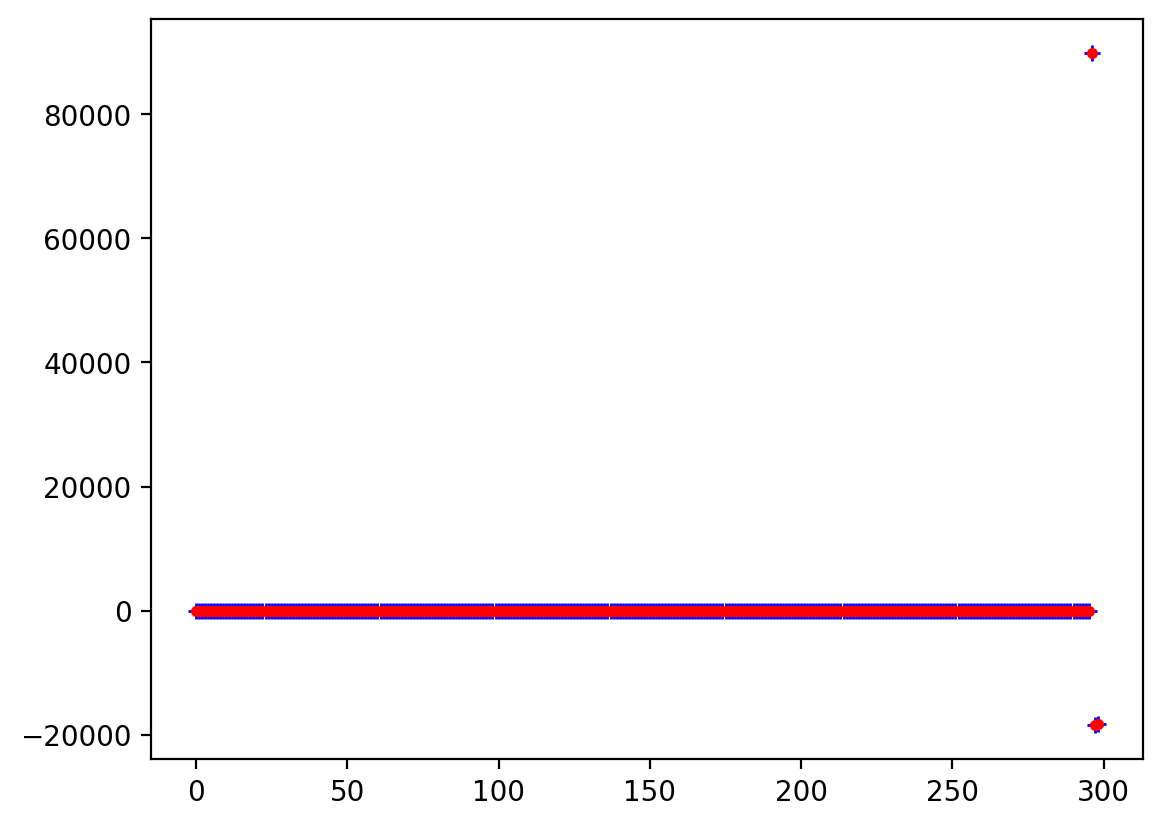

In [95]:
import numpy as np


# Example: Define an arbitrary loss function
def loss_function_pre(x_pre):
    # Compute the preconditioned loss
    residual = A_pre @ x_pre - b_pre
    coupling_loss = 0.0
    current_state_vector = x_pre * D_inv
    estimation_qp.state_vector = current_state_vector
    n_oob_all_meshes = get_n_oob_all_meshes(
        operators,
        index,
        meshes,
        estimation_qp,
    )
    print(f"{n_oob_all_meshes=}")
    print(f"{0.5 * np.dot(residual.T, residual)=}")
    coupling_loss = 1e2 * n_oob_all_meshes
    return 0.5 * np.dot(residual.T, residual) + coupling_loss


def gradient_pre(x_pre):
    # Compute the gradient for the preconditioned system
    return A_pre.T @ (A_pre @ x_pre - b_pre)


# Conjugate Gradient for preconditioned system
def conjugate_gradient_preconditioned(L, grad, x0, D_inv, tol=1e-6, max_iter=10):
    """
    Conjugate Gradient for arbitrary loss functions with column preconditioning.
    Args:
        L: Loss function
        grad: Gradient of the loss
        x0: Initial guess
        D_inv: Inverse of column scaling matrix
        tol: Convergence tolerance
        max_iter: Maximum iterations
    Returns:
        x: Original solution vector
    """
    x_pre = x0  # Preconditioned solution
    g_pre = grad(x_pre)
    p_pre = -g_pre

    for k in range(max_iter):
        print(f"{k=}")
        # Line search to find optimal step size
        alpha = line_search(L, grad, x_pre, p_pre)
        x_pre_new = x_pre + alpha * p_pre

        # Check convergence
        g_pre_new = grad(x_pre_new)
        if np.linalg.norm(g_pre_new) < tol:
            print(f"Converged in {k+1} iterations.")
            return x_pre_new * D_inv  # Rescale back to original solution

        # Update direction
        beta = np.dot(g_pre_new, g_pre_new) / np.dot(g_pre, g_pre)
        p_pre = -g_pre_new + beta * p_pre

        # Update variables for next iteration
        x_pre, g_pre = x_pre_new, g_pre_new

    print("Reached maximum iterations.")
    return x_pre * D_inv  # Rescale back to original solution


# Example inputs
np.random.seed(0)
# m, n = 100, 50
# A = np.random.randn(m, n)
# b = np.random.randn(m)

A = operators.eigen * np.sqrt(weighting_vector_eigen[:, None])
b = data_vector_eigen * np.sqrt(weighting_vector_eigen)
m, n = A.shape


# Step 1: Column Preconditioning
column_norms = np.linalg.norm(A, axis=0) + 1e-8  # Avoid division by zero
D_inv = 1 / column_norms
A_pre = A * D_inv  # Preconditioned matrix
b_pre = b  # b remains unchanged

# Step 2: Initial guess and line search
x0 = np.zeros(n)


def line_search(L, grad, x, p, alpha_init=1.0, tol=1e-4):
    alpha = alpha_init
    c = 1e-4
    while L(x + alpha * p) > L(x) + c * alpha * np.dot(grad(x), p):
        alpha *= 0.5  # Reduce step size
        if alpha < 1e-8:
            break
    return alpha


# CG solve
x_sol = conjugate_gradient_preconditioned(loss_function_pre, gradient_pre, x0, D_inv)

plt.figure()
plt.plot(estimation_qp.state_vector, "b+")
plt.plot(x_sol, "r.")
plt.show()

# print("Solution x (with column preconditioning):", x_sol)

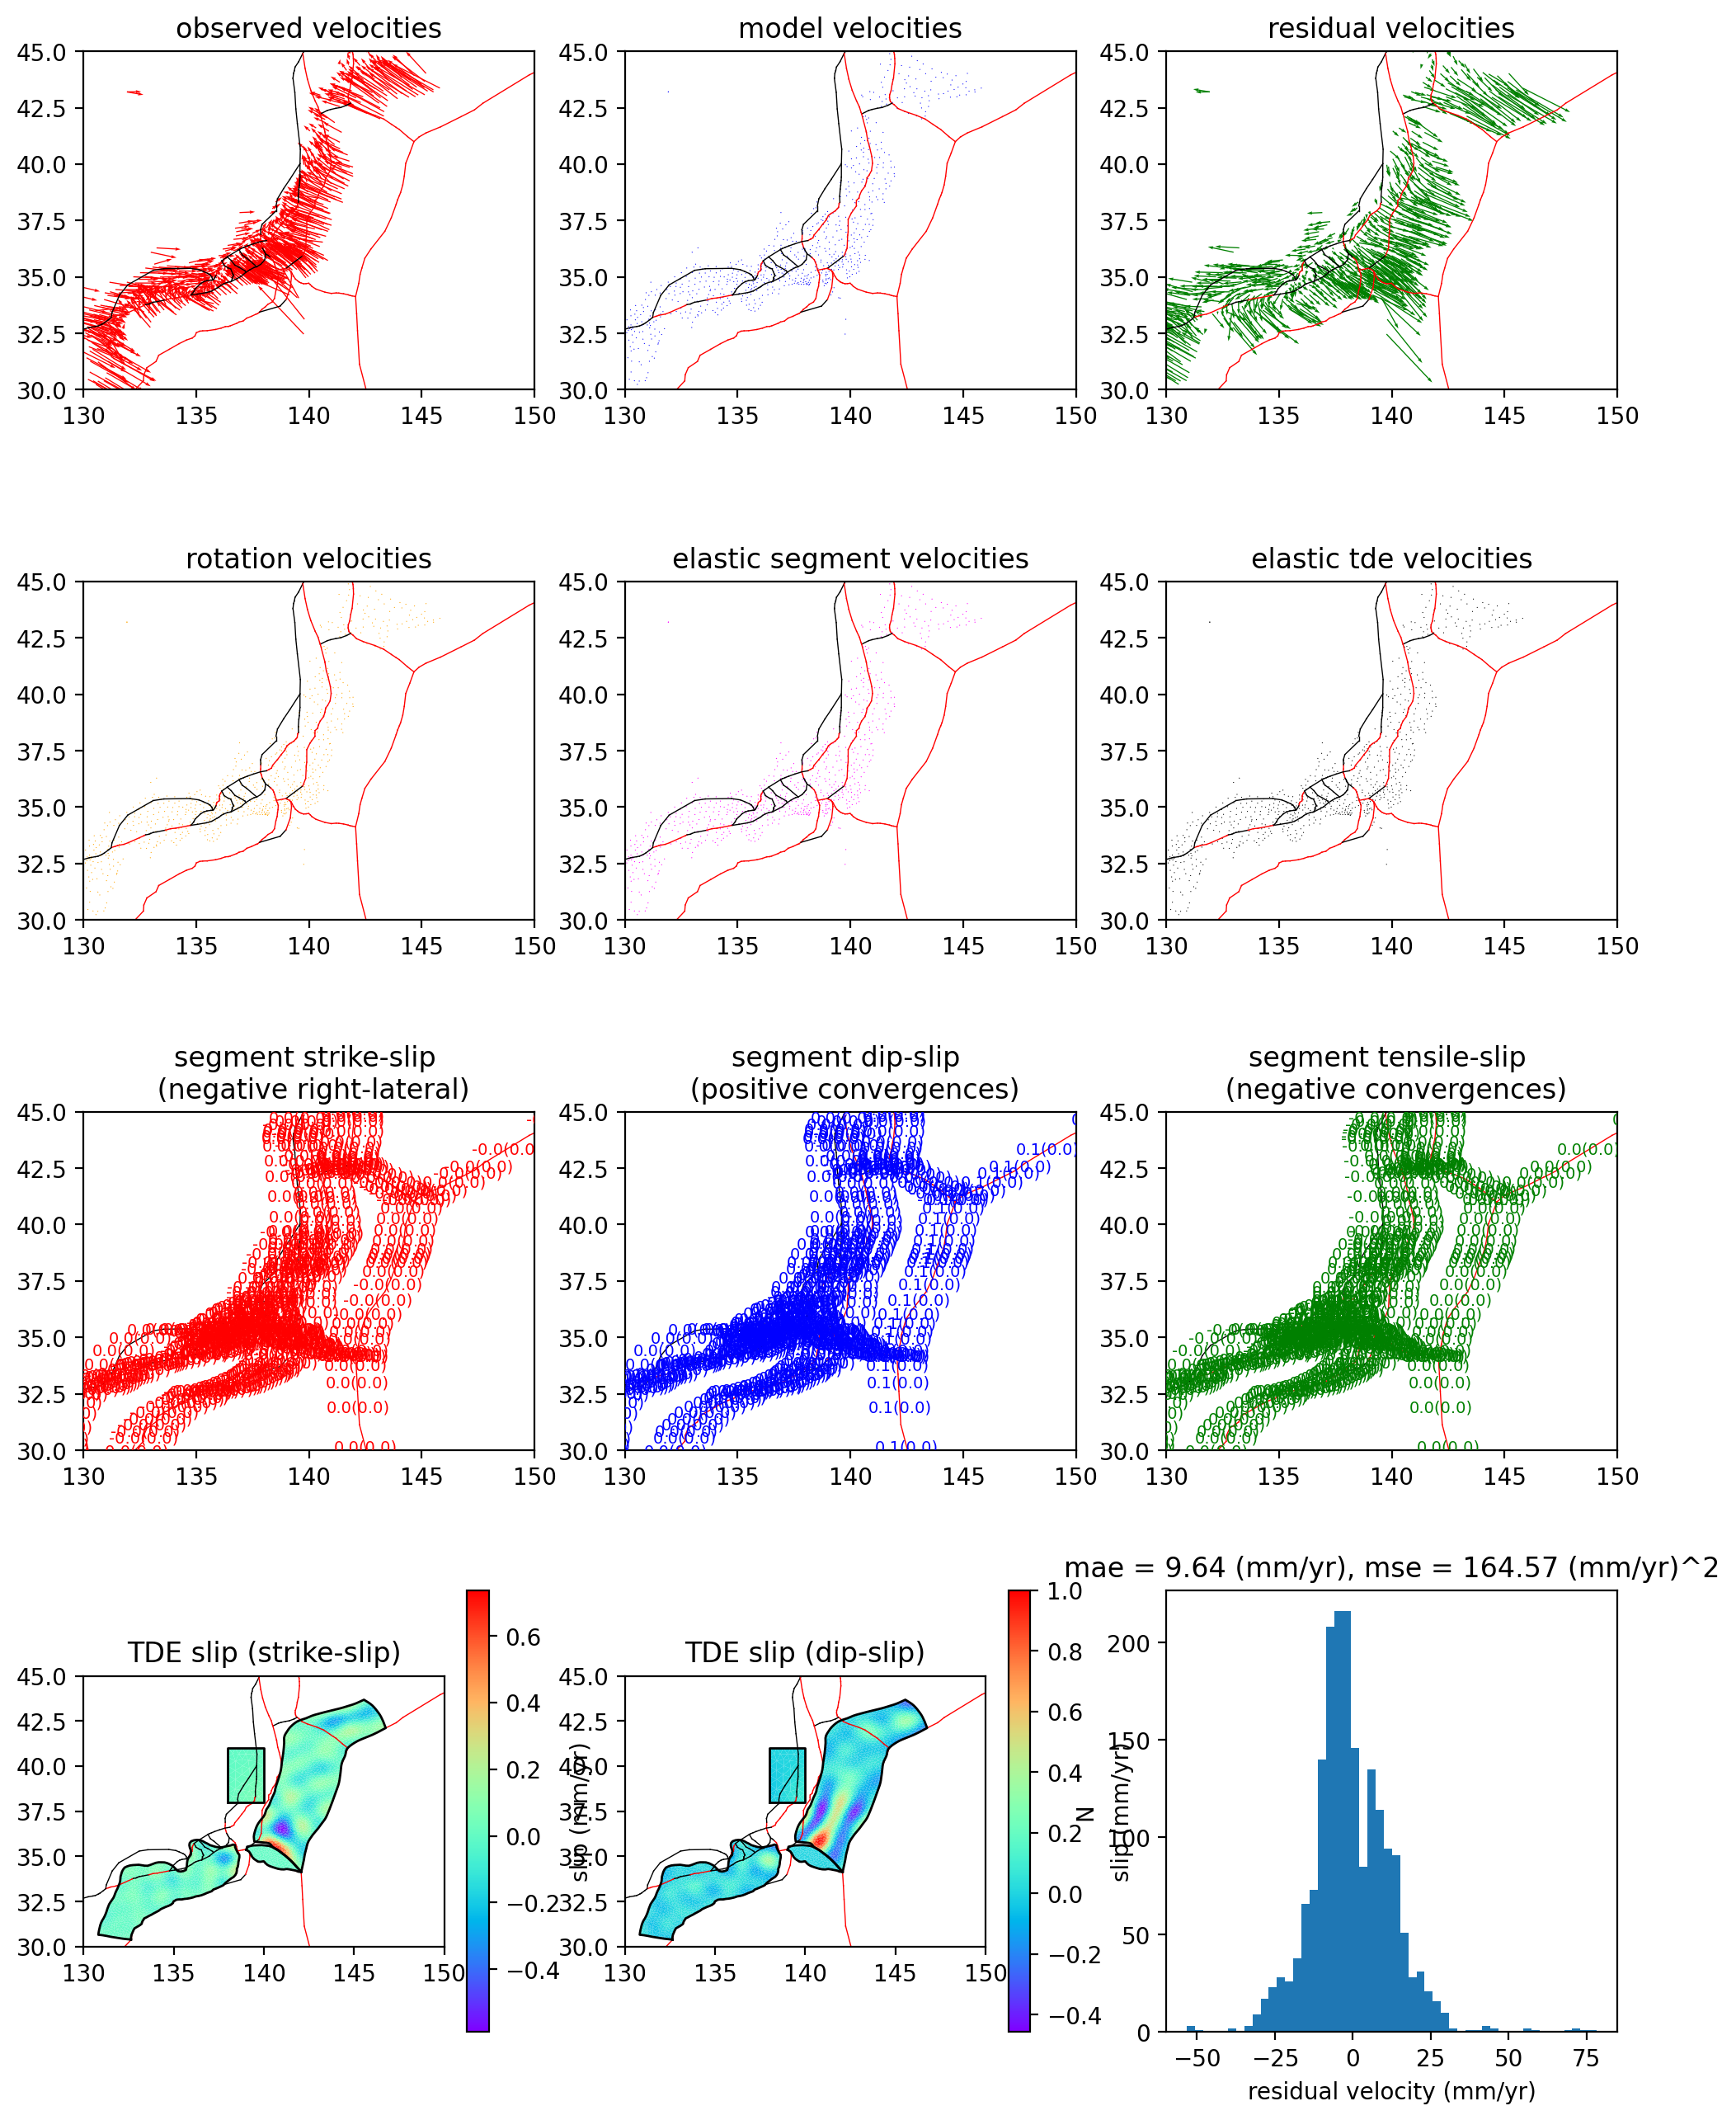

SUCCESS: Wrote figures../runs/0000000852/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6672 - 2024-12-18 13:39:17


<Figure size 640x480 with 0 Axes>

: 

: 

: 

In [92]:
estimation_cg = copy.deepcopy(estimation_qp)
estimation_cg.state_vector = x_sol
celeri.post_process_estimation_eigen(estimation_cg, operators, station, index)

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_cg,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

: 

: 

: 